## 0. Installations and Contents
Please create a new virtual environment before running this code
The required packages are:
- numpy
- pandas
- matplotlib
- networkx
- pyomo
- gurobi

You can install these packages directly from the requirements.txt (python 3.10) or install them manually in your desired environment

### Notes:
- This project contains: DC powerflow tools, network plotting tools, and a Redispatch DC OPF based on some redispatch order book
- The code is applied to a small fictional Transmission grid, and is not optimized. You will see loops over dataframes etc. Feel free to optimize the code where you can
- All necessary data is defined in the notebook and is not stored in seperate files
- Only the plotting and OPF debugging files are seperate
- I have been a bit consistent with the indexing (in the pyomo model, we start with 0 and we start with 1 when defining the data). The code seems to be correct in the current form, but this would be a point of improvement for the future.
- Though the network plots work, they seem to be a bit inconsistent in terms of the orrientation and overlap of edges. This seems to be characterized by a random seed, because we get a different result with every run. This can also be a point of further improvement
- Feel free to provide the input and format the outputs of the code in your desired form!

## 1. Setting up the network and performing a DC Powerflow

### Set up a very simple network
- Ring structure
- 2 loads, 2 generators
- 8 buses and 8 lines
- generators and bus 1 and 2
- loads at bus 3 and 4
- Assume equal cable properties for all lines (reactance and capacity)
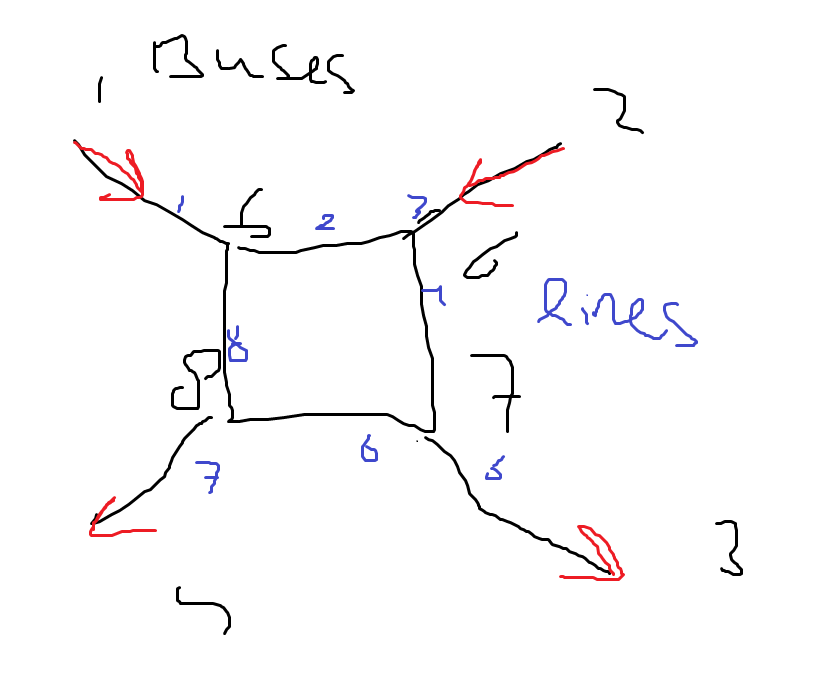

In [1]:
import numpy as np
import pandas as pd

line_data = {'from_bus': [1, 5, 2, 6, 3, 7, 4, 8],
            'to_bus': [5, 6, 6, 7, 7, 8, 8, 5]}  # all lines the same susceptance

df_lines = pd.DataFrame(line_data)
# df_lines.index = range(1, 1 + len(df_lines))
n_lines = len(df_lines)

print(df_lines)

   from_bus  to_bus
0         1       5
1         5       6
2         2       6
3         6       7
4         3       7
5         7       8
6         4       8
7         8       5


### DC powerflow equations
Source image: https://drive.google.com/file/d/1vTYyhAtNHbnC4kr_ZAASr1AFp9HJzZw4/view (= great resource from https://www.jalalkazempour.com/teaching)


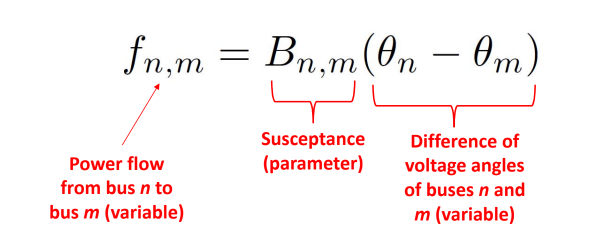

### Note on units of loads and susceptance: the per unit system
- suspectance is 1/X with X in Ohm
- if we assume 0.1 Ohm/km for the reactance
- and a length of about 100 km
- we get X = 10 Ohm
- susceptance is 0.1 1/Ohm = 0.1 S
- We choose a MW base for our per unit system: S_base = 1 MW
- susceptance = 1/Z_pu * susceptance pu
- Where Z_pu = V_base^2/S_base
- Let's take V_base = 380 kV
- Z_pu = 380^2 = 129600
- susceptance pu = 0.1 * 129600 is about 1.0e4

### Calculate B matrix

In [2]:
line_capacity = 100.0 # pu (MW)
susceptance = 1.0e4  # pu

df_lines['susceptance'] = susceptance
df_lines['capacity'] = line_capacity


# Define the number of buses and lines
buses = sorted(set(df_lines['from_bus']).union(set(df_lines['to_bus'])))
n_buses = len(buses)

# Build the susceptance matrix (B matrix)
B = np.zeros((n_buses, n_buses))

for _, row in df_lines.iterrows():
    from_idx = buses.index(row['from_bus'])
    to_idx = buses.index(row['to_bus'])
    B[from_idx, to_idx] -= row['susceptance']
    B[to_idx, from_idx] -= row['susceptance']
    B[from_idx, from_idx] += row['susceptance']
    B[to_idx, to_idx] += row['susceptance']

### Visualize network
I programmed some basic network visualization functions in the file network_plotting.py

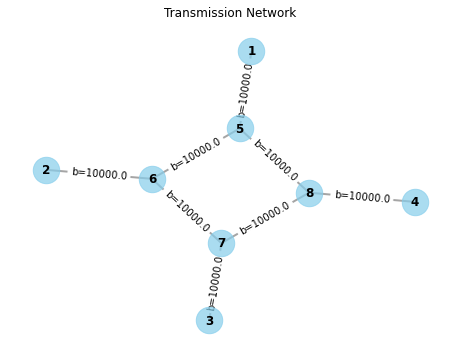

In [3]:
from network_plotting import draw_network, draw_network_with_power_flows, draw_network_with_absolute_power_flows

draw_network(df_lines)

### Do DC powerflow
For more information on the logic, see e.g. https://www.engineering.iastate.edu/~jdm/ee553/DCPowerFlowEquations.pdf

In [4]:
def calculate_powerflow(loads: np.array) -> pd.DataFrame:
    # Initialize results df
    df_results = pd.DataFrame({'flow': n_lines * [0.0]}, index=df_lines.index)
    
    # Remove the reference bus (slack bus) to make the matrix non-singular
    # Assume bus 1 is the slack bus
    slack_bus = 0
    B_reduced = np.delete(B, slack_bus, axis=0)
    B_reduced = np.delete(B_reduced, slack_bus, axis=1)
    
    # Adjust the load vector to exclude the slack bus
    load_reduced = np.delete(loads, slack_bus)

    # Solve for the phase angles (theta) at the non-slack buses
    theta_reduced = np.linalg.solve(B_reduced, load_reduced)

    # Reconstruct the full theta vector including the slack bus (assumed 0 phase angle)
    theta = np.zeros(n_buses)
    theta[1:] = theta_reduced

    # Calculate line flows    
    df_results['flow'] = [
        row['susceptance'] * (theta[buses.index(row['from_bus'])] - theta[buses.index(row['to_bus'])])
        for _, row in df_lines.iterrows()
    ]

    print("Bus phase angles (theta):")
    for i, angle in enumerate(theta):
        print(f"Bus {buses[i]}: {angle:.4f} rad")

    print("\nLine flows:")
    print(df_results)
    
    return df_results
    
# Define loads at buses (positive for load, negative for generation)
loads = np.zeros(n_buses)
loads[0] = 100  # Generation at bus 1, MW
loads[1] = 100  # Generation at bus 2, MW
loads[2] = -120  # Load at bus 3, MW
loads[3] = -80 # Load at bus 4, MW


df_flows = calculate_powerflow(loads)

Bus phase angles (theta):
Bus 1: 0.0000 rad
Bus 2: -0.0005 rad
Bus 3: -0.0330 rad
Bus 4: -0.0275 rad
Bus 5: -0.0100 rad
Bus 6: -0.0105 rad
Bus 7: -0.0210 rad
Bus 8: -0.0195 rad

Line flows:
    flow
0  100.0
1    5.0
2  100.0
3  105.0
4 -120.0
5  -15.0
6  -80.0
7  -95.0


### Visualize load flow

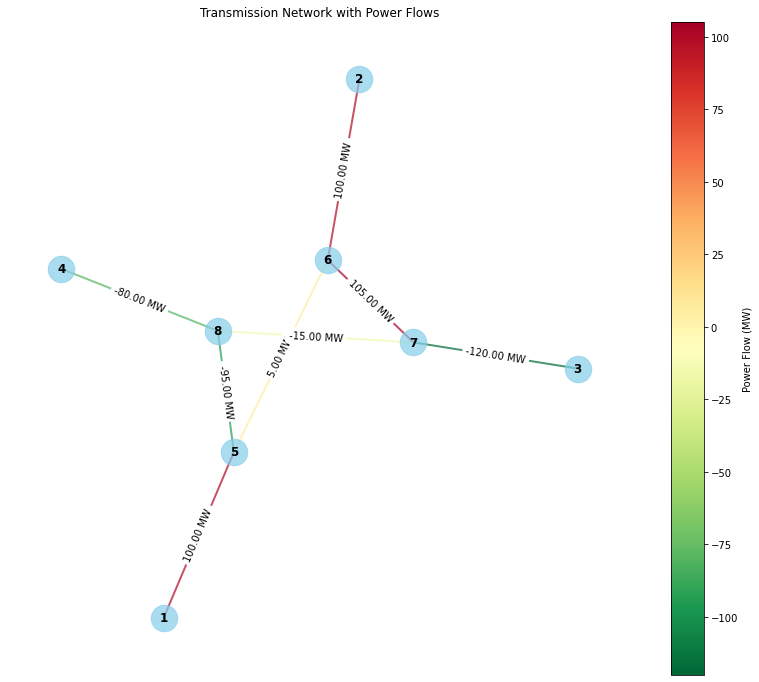

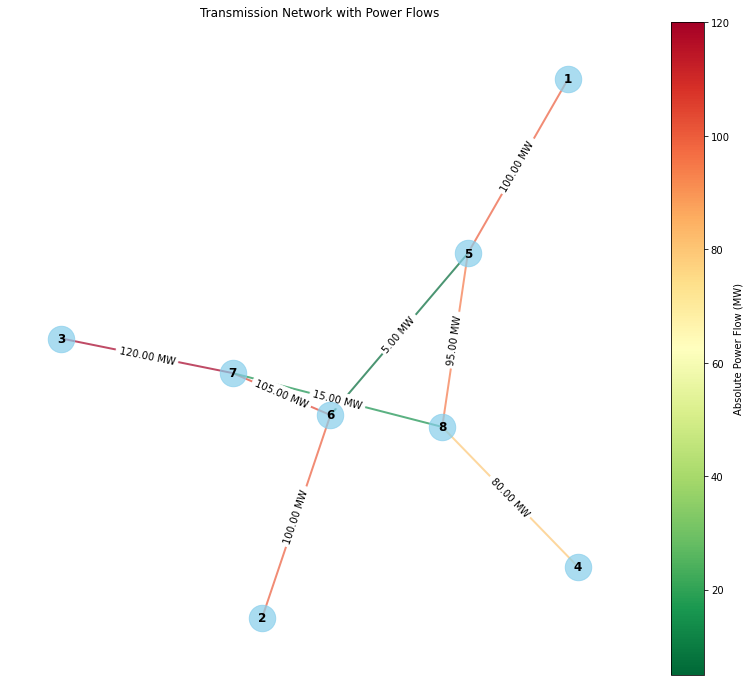

In [5]:
from network_plotting import draw_network_with_power_flows, draw_network_with_absolute_power_flows

draw_network_with_power_flows(df_lines, df_flows)

draw_network_with_absolute_power_flows(df_lines, df_flows)

### Observe:
- flows are what we expect
- voltage angles difference are small

## 2. Getting the prognosis for all load/generators

Text(0.5, 1.0, 'Prognosis')

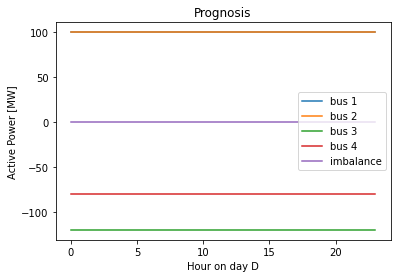

In [6]:
import matplotlib.pyplot as plt
prognosis_data = {'bus 1': 24 * [100.0], 'bus 2': 24 * [100.0], 'bus 3': 24 * [-120.0], 'bus 4': 24 * [-80.0]}  # hourly
df_prognosis = pd.DataFrame(prognosis_data)
df_prognosis['imbalance'] = df_prognosis.sum(axis=1)

fig, ax = plt.subplots()
df_prognosis.plot(ax=ax)
ax.set_xlabel("Hour on day D")
ax.set_ylabel("Active Power [MW]")
ax.set_title("Prognosis")

Bus phase angles (theta):
Bus 1: 0.0000 rad
Bus 2: -0.0005 rad
Bus 3: -0.0330 rad
Bus 4: -0.0275 rad
Bus 5: -0.0100 rad
Bus 6: -0.0105 rad
Bus 7: -0.0210 rad
Bus 8: -0.0195 rad

Line flows:
    flow
0  100.0
1    5.0
2  100.0
3  105.0
4 -120.0
5  -15.0
6  -80.0
7  -95.0


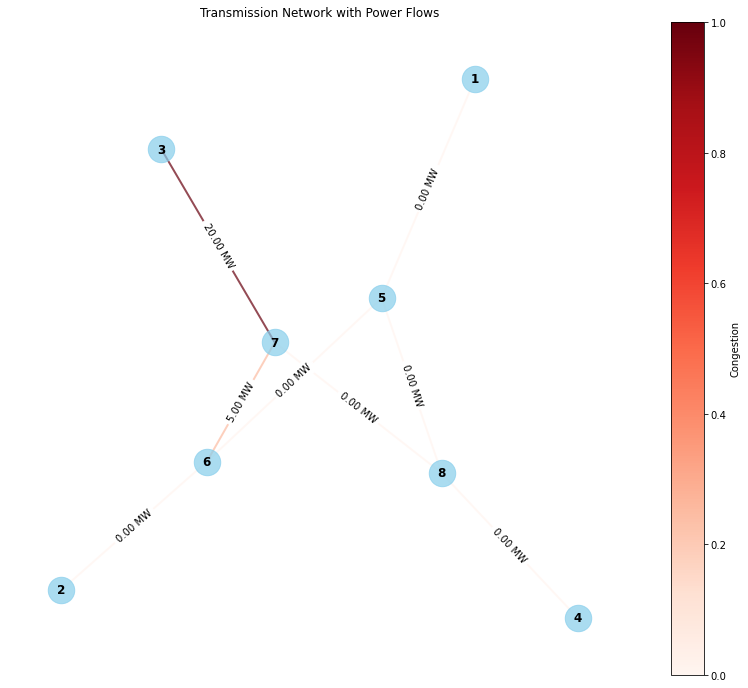

In [7]:
from network_plotting import draw_network_with_congestion

# Calculate load flow on the first value
df_flows =  calculate_powerflow(loads=list(df_prognosis[['bus 1', 'bus 2', 'bus 3', 'bus 4']].iloc[0].values) + [0.0, 0.0, 0.0, 0.0])
draw_network_with_congestion(df_lines, df_flows)

### Observe:
- We assume a constant profile over the whole day
- We don't have any system imbalance from the prognosis
- We have congestion in 2 lines

## 3. Getting the Redispatch Order Book

In [8]:
data_orderbook = {'bus': [1, 3, 2], 
                   'delivery_start': [4, 1, 6],  # in 1, ..., 24
                   'delivery_end': [12, 12, 18],  # in 1, ..., 24
                   'buy/sell': ['buy', 'sell', 'buy'], # in {buy, sell}
                   'price': [-20.0, 100.0, 20.0], # Eur/MWh reals, [-100.0, 100.0]
                   'power': [30.0, 20.0, 10.0]  #  MW, reals  
                  }

df_ob = pd.DataFrame(data_orderbook)
print(df_ob)

   bus  delivery_start  delivery_end buy/sell  price  power
0    1               4            12      buy  -20.0   30.0
1    3               1            12     sell  100.0   20.0
2    2               6            18      buy   20.0   10.0


### Create hypothesis for the solution of the market clearing

In [9]:
loads = np.zeros(n_buses)
loads[0] = 100 - 20  # Generation at bus 1, MW
loads[1] = 100  # Generation at bus 2, MW
loads[2] = -120 + 20  # Load at bus 3, MW
loads[3] = -80 # Load at bus 4, MW


df_flows = calculate_powerflow(loads)

loads[0] = 100 - 10  # Generation at bus 1, MW
loads[1] = 100 - 10  # Generation at bus 2, MW
loads[2] = -120 + 20  # Load at bus 3, MW
loads[3] = -80 # Load at bus 4, MW


df_flows = calculate_powerflow(loads)

Bus phase angles (theta):
Bus 1: 0.0000 rad
Bus 2: 0.0025 rad
Bus 3: -0.0270 rad
Bus 4: -0.0245 rad
Bus 5: -0.0080 rad
Bus 6: -0.0075 rad
Bus 7: -0.0170 rad
Bus 8: -0.0165 rad

Line flows:
    flow
0   80.0
1   -5.0
2  100.0
3   95.0
4 -100.0
5   -5.0
6  -80.0
7  -85.0
Bus phase angles (theta):
Bus 1: 0.0000 rad
Bus 2: -0.0002 rad
Bus 3: -0.0285 rad
Bus 4: -0.0257 rad
Bus 5: -0.0090 rad
Bus 6: -0.0092 rad
Bus 7: -0.0185 rad
Bus 8: -0.0177 rad

Line flows:
    flow
0   90.0
1    2.5
2   90.0
3   92.5
4 -100.0
5   -7.5
6  -80.0
7  -87.5


### Observe:
- We can solve the congestion between 4 and 12 by accepting 20 MW at bus 3
- Between 4 and 6 we fully clear with bus 1. Between 6 and 12 we partially clear with the cheaper bid from 2, and clear the remainder with 1
- Congestion remains at other ptus
- A buy order corresponds with consuming more or generating less -> decrease in load
- A sell order corresponds with consuming less are generating more -> increase in load

Note: it is good to apply some checks to the order book. Currently, the optimization model does not deal well with instances of "negative spreads". These should not occur, but it is good to check

## 4. Solving the redispatch market order clearing on the network
We solve an optimization problem

- We want to minimize: congestion (priority 1), costs (priority 2)
    - Note: formally, we have 2 objectives
    - Note: if costs would be the first priority, we would never use redispatch (unless it is free)
- Indices:
    - over buses
    - over lines
    - over time
- Variables:
    - Voltage angles at every node and every time
    - Power flows through every line and every time
    - Congestion through every line and every time
    - Active power at every node at every time
    - Activated redispatch volume at every node and every time
- Constraints
    - Define congestion
        - for the case f >= 0
        - for the case f < 0
    - DC powerflow equations
        - voltage angle at bus 1 is 0
        - relation between P and voltage angle and B (see section 2 of this document)
        - energy conservation at every node
    - Redispatch market clearing
        - cleared buy vol == cleared sell vol (no imbalance caused)
        - cleared buy vol and sell vol at every node should never be more than the volumes submitted in the order book

### Data preparation
- get for all buses and times the max redispatch value and the prices
- set prognosis for all buses and all times

Note: pyomo likes getting dicts for initialization


In [10]:
max_redispatch = np.zeros((n_buses, 24))
redispatch_price = np.zeros((n_buses, 24))
p_prognosis = np.zeros((n_buses, 24))

for _, row in df_ob.iterrows():
    new_power = row['power'] if row['buy/sell'] == 'sell' else - row['power']
    max_redispatch[row['bus'] - 1, row['delivery_start'] - 1: row['delivery_end']] = new_power
    redispatch_price[row['bus'] - 1, row['delivery_start'] - 1: row['delivery_end']] = row['price']

bus_col_names = [col_name for col_name in df_prognosis.columns if 'bus ' in col_name]
bus_ids = [int(col_name.split(" ")[1]) - 1 for col_name in bus_col_names]
p_prognosis[bus_ids, :] = df_prognosis[bus_col_names].values.T


# Convert to dicts for pyomo initialization
max_redispatch_dict = {index: value for index, value in np.ndenumerate(max_redispatch)}
redispatch_price_dict = {index: value for index, value in np.ndenumerate(redispatch_price)}
p_prognosis_dict = {index: value for index, value in np.ndenumerate(p_prognosis)}

### Multi-objective
- we minimize congestion first and costs second
- We can use multiple multi-objective optimization techniques to do this
- We take simple approach by weighin the two objectives like:

(1 -epsilon) congestion + epsilon costs

For some small epsilon

In [11]:
epsilon = 0.0005 # MWh/Eur, small value to balance the two objectives

### Build the model

In [12]:
import pyomo.environ as pyo
from pyomo.opt import SolverFactory
import os

model = pyo.ConcreteModel()

# Define indices
model.bus_set = pyo.RangeSet(0, n_buses - 1)
model.line_set = pyo.RangeSet(0, n_lines - 1)
model.time_set = pyo.RangeSet(0, 23)  # includes 23

# Define parameters
model.dt = pyo.Param(initialize=1.0)  # 1 hour time resolution
model.max_dp = pyo.Param(model.bus_set, model.time_set, within=pyo.Reals, initialize=max_redispatch_dict)
model.price = pyo.Param(model.bus_set, model.time_set, within=pyo.Reals, initialize=redispatch_price_dict)
model.p_prognosis = pyo.Param(model.bus_set, model.time_set, within=pyo.Reals, initialize=p_prognosis_dict)

# Define variables
model.theta = pyo.Var(model.bus_set, model.time_set, within=pyo.Reals)
model.f = pyo.Var(model.line_set, model.time_set, within=pyo.Reals)
model.congestion = pyo.Var(model.line_set, model.time_set, within=pyo.NonNegativeReals)  # >= 0
model.p = pyo.Var(model.bus_set, model.time_set, within=pyo.Reals)  # redispatch
model.dp = pyo.Var(model.bus_set, model.time_set, within=pyo.Reals)  # redispatch

model.total_congestion = pyo.Var(within=pyo.NonNegativeReals)
model.total_costs = pyo.Var(within=pyo.Reals)

# Define objective function
def def_total_congestion(m):
    return m.total_congestion ==  sum(sum(m.congestion[l, t] * m.dt for l in m.line_set) for t in m.time_set)

model.con_def_total_congestion = pyo.Constraint(rule=def_total_congestion)

def def_total_costs(m):
    return m.total_costs == sum(sum(m.dp[b, t] * m.price[b, t] * m.dt for b in m.bus_set) for t in m.time_set)

model.con_def_total_costs = pyo.Constraint(rule=def_total_costs)

def objective_function(m):
    return (1.0 - epsilon) * m.total_congestion + epsilon * m.total_costs

model.objective_function = pyo.Objective(sense=pyo.minimize, expr=objective_function)

def lb_total_costs(m):
    return m.total_costs >= 0

# model.lb_total_costs = pyo.Constraint(rule=lb_total_costs)

# Define Constraints
def def_congestion_1(m, l, t):
    capacity = df_lines.iloc[l]['capacity']
    return m.congestion[l, t] >= m.f[l, t] - capacity 

model.con_def_congestion_1 = pyo.Constraint(model.line_set, model.time_set, rule=def_congestion_1)

def def_congestion_2(m, l, t):
    capacity = df_lines.iloc[l]['capacity']
    return m.congestion[l, t] >= -m.f[l, t] - capacity 

model.con_def_congestion_2 = pyo.Constraint(model.line_set, model.time_set, rule=def_congestion_2)

# DC powerflow equations
def ref_theta(m, t):
    return m.theta[0, t] == 0.0

model.con_ref_theta = pyo.Constraint(model.time_set, rule=ref_theta)

def DC_flow(m, l, t):
    from_bus = df_lines.iloc[l]['from_bus'] - 1  # Convert to zero-based index
    to_bus = df_lines.iloc[l]['to_bus'] - 1      # Convert to zero-based index
    susceptance = df_lines.iloc[l]['susceptance']
    return m.f[l, t] == susceptance * (m.theta[from_bus, t] - m.theta[to_bus, t])

model.con_DC_flow = pyo.Constraint(model.line_set, model.time_set, rule=DC_flow)

def nodal_power_balance(m, b, t):
    inflows = sum(m.f[l, t] for l in model.line_set if df_lines.iloc[l]['to_bus'] - 1 == b)
    outflows = sum(m.f[l, t] for l in model.line_set if df_lines.iloc[l]['from_bus'] - 1 == b)
    return inflows - outflows + m.p[b, t] == 0

model.con_nodal_power_balance = pyo.Constraint(model.bus_set, model.time_set, rule=nodal_power_balance)

# Define p
def def_p(m, b, t):
    return m.p[b, t] == m.p_prognosis[b, t] + m.dp[b, t]

model.con_def_p = pyo.Constraint(model.bus_set, model.time_set, rule=def_p)


# Bound dp from below and above
def lower_bound_dp(m, b, t):
    if m.max_dp[b, t] >= 0:
        return m.dp[b, t] >= 0
    else:
        return m.dp[b, t] >= m.max_dp[b, t]
    
model.con_lower_bound_dp = pyo.Constraint(model.bus_set, model.time_set, rule=lower_bound_dp)
    
def upper_bound_dp(m, b, t):
    if m.max_dp[b, t] >= 0:
        return m.dp[b, t] <= m.max_dp[b, t]
    else:
        return m.dp[b, t] <= 0.0

model.con_upper_bound_dp = pyo.Constraint(model.bus_set, model.time_set, rule=upper_bound_dp)


# Cleared buy = cleared sell
def dp_balance(m, t):
    return sum(m.dp[b, t] for b in m.bus_set) == 0.0

model.con_dp_balance = pyo.Constraint( model.time_set, rule=dp_balance)

# Store model (convenient for debugging)
path = os.getcwd() + '\\'
model.write(path + "model.lp", io_options={"symbolic_solver_labels": True})

('C:\\Users\\s147670\\Code\\Redispatch DC OPF\\model.lp', 2251105694048)

### Solve the model

In [13]:
opt = SolverFactory('gurobi')
opt.options['mipgap'] = 0.001
opt.options['DualReductions'] = 0
results = opt.solve(model, tee=True)

termination_condition = results.solver.termination_condition

if termination_condition == pyo.TerminationCondition.infeasible:
    print("Model is infeasible.")
elif termination_condition == pyo.TerminationCondition.unbounded:
    print("Model is unbounded.")
elif termination_condition == pyo.TerminationCondition.infeasibleOrUnbounded:
    print("Model is either infeasible or unbounded.")
else:
    print(f"Termination condition: {termination_condition}")

Set parameter Username

--------------------------------------------
--------------------------------------------

Academic license - for non-commercial use only - expires 2024-12-18
Read LP format model from file C:\Users\s147670\AppData\Local\Temp\tmpcrz74mnu.pyomo.lp
Reading time = 0.04 seconds
x963: 1395 rows, 963 columns, 3133 nonzeros
Set parameter MIPGap to value 0.001
Set parameter DualReductions to value 0
Gurobi Optimizer version 10.0.0 build v10.0.0rc2 (win64)

CPU model: Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 1395 rows, 963 columns and 3133 nonzeros
Model fingerprint: 0x9244d854
Coefficient statistics:
  Matrix range     [1e+00, 1e+04]
  Objective range  [5e-04, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+02]
Presolve time: 0.00s
Presolved: 25 rows, 215 columns, 64 nonzeros

Iteration    Objective       Primal Inf

### Check results

In [14]:
# Get results from the model
dp_results = {(b, t): pyo.value(model.dp[b, t]) for b in model.bus_set for t in model.time_set}
f_results = {(l, t): pyo.value(model.f[l, t]) for l in model.line_set for t in model.time_set}
congestion_results = {(l, t): pyo.value(model.congestion[l, t]) for l in model.line_set for t in model.time_set}

total_congestion_results = pyo.value(model.total_congestion)
total_costs_results = pyo.value(model.total_costs)
of_results = total_congestion_results + epsilon * total_costs_results

# Print some information on the objective function
print(f"Objective value is: {total_congestion_results} + {epsilon} x {total_costs_results} = {of_results}")
print(f"Cost term is {round(100.0 * total_costs_results * epsilon/of_results, 2)}% of the total OF (should be small)")

# Convert dicts to dataframes
# Create a DataFrame from the dictionary
df_dp = pd.DataFrame.from_dict(dp_results, orient='index', columns=['value'])
df_f = pd.DataFrame.from_dict(f_results, orient='index', columns=['value'])
df_congestion = pd.DataFrame.from_dict(congestion_results, orient='index', columns=['value'])

# Convert the index into two separate columns: 'bus' and 'time'
df_dp.index = pd.MultiIndex.from_tuples(df_dp.index, names=['bus', 'time'])
df_f.index = pd.MultiIndex.from_tuples(df_f.index, names=['line', 'time'])
df_congestion.index = pd.MultiIndex.from_tuples(df_congestion.index, names=['line', 'time'])
df_dp.reset_index(inplace=True)
df_f.reset_index(inplace=True)
df_congestion.reset_index(inplace=True)

# Pivot to make buses columns and times the index
df_dp = df_dp.pivot(index='time', columns='bus', values='value')
df_f = df_f.pivot(index='time', columns='line', values='value')
df_congestion = df_congestion.pivot(index='time', columns='line', values='value')

Objective value is: 375.0 + 0.0005 x 18800.0 = 384.4
Cost term is 2.45% of the total OF (should be small)


In [15]:
df_dp

bus,0,1,2,3,4,5,6,7
time,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-20.0,0.0,20.0,0.0,0.0,0.0,0.0,0.0
4,-20.0,0.0,20.0,0.0,0.0,0.0,0.0,0.0
5,-10.0,-10.0,20.0,0.0,0.0,0.0,0.0,0.0
6,-10.0,-10.0,20.0,0.0,0.0,0.0,0.0,0.0
7,-10.0,-10.0,20.0,0.0,0.0,0.0,0.0,0.0
8,-10.0,-10.0,20.0,0.0,0.0,0.0,0.0,0.0


In [16]:
df_f

line,0,1,2,3,4,5,6,7
time,,,,,,,,
0,100.0,5.0,100.0,105.0,-120.0,-15.0,-80.0,-95.0
1,100.0,5.0,100.0,105.0,-120.0,-15.0,-80.0,-95.0
2,100.0,5.0,100.0,105.0,-120.0,-15.0,-80.0,-95.0
3,80.0,-5.0,100.0,95.0,-100.0,-5.0,-80.0,-85.0
4,80.0,-5.0,100.0,95.0,-100.0,-5.0,-80.0,-85.0
5,90.0,2.5,90.0,92.5,-100.0,-7.5,-80.0,-87.5
6,90.0,2.5,90.0,92.5,-100.0,-7.5,-80.0,-87.5
7,90.0,2.5,90.0,92.5,-100.0,-7.5,-80.0,-87.5
8,90.0,2.5,90.0,92.5,-100.0,-7.5,-80.0,-87.5


In [17]:
df_congestion

line,0,1,2,3,4,5,6,7
time,,,,,,,,
0,0.0,0.0,0.0,5.0,20.0,0.0,0.0,0.0
1,0.0,0.0,0.0,5.0,20.0,0.0,0.0,0.0
2,0.0,0.0,0.0,5.0,20.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Observations: 
- We get the expected results!
- Epsilon is small enough to make the costs small compared to the congestion
- We can use the network plot functionalities from earlier if we get the output data in the right format again